# House Prices Prediction Notebook

## Importing Libraries

In [80]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_log_error, make_scorer
 
import xgboost as xgb

from sklearn.preprocessing import LabelEncoder

# Setting the option to show all the df columns
pd.set_option('display.max_columns', None)

## Reading The Dataframe

In [81]:
# Reading the train df
train_df = pd.read_csv('train.csv')

# Reading the test df
test_df = pd.read_csv('test.csv')

In [82]:
# Train df
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [83]:
print('The train df contains {} rows and {} columns'.format(train_df.shape[0], train_df.shape[1]))

The train df contains 1460 rows and 81 columns


In [84]:
print('The test df contains {} rows and {} columns'.format(test_df.shape[0], test_df.shape[1]))

The test df contains 1459 rows and 80 columns


## The distribution of "SalePrice" values

In [85]:
sns.set_style('darkgrid')

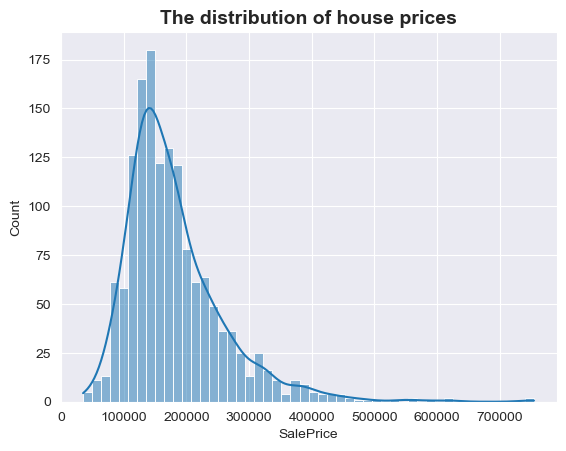

In [86]:
sns.histplot(data=train_df['SalePrice'], bins=50, kde=True)

plt.title('The distribution of house prices', fontsize=14, fontweight = 'bold')
plt.show()

## Data Cleaning

All the data will be cleaned based on column types and also by columns definitions, which can be found on "data_description.txt"

In [87]:
# Creating functions to fill null values 
# Based on column definition, null values will be filled diferentely

# Function for filling with mean
def fill_mean(df, column):
    """
    This function fill null values of a specific column 
    with the average value of that column
    """
    df[column].fillna(df[column].mean(), inplace=True)
    
# Function for filling with mode
def fill_mode(df, column):
    """
    This function fill null values of a specific column 
    with the mode value of that column
    """
    df[column].fillna(df[column].mode()[0], inplace=True)
    
# Function for filling with none
def fill_none(df, column):
    """
    This function fill null values of a specific column 
    with 'None'
    """
    df[column].fillna('None', inplace=True)
    
# Function for filling with zero
def fill_zero(df, column):
    """
    This function fill null values of a specific column 
    with zero
    """
    df[column].fillna(0.0, inplace=True)

### Filling null values of Train df

In [89]:
# Checking columns with null values in Train DF

# Calculating the number of null values in train df
nulls_train = train_df.isna().sum()[train_df.isna().sum() > 0].reset_index().rename(columns={0:'#_of_nulls'})

# Calculating the perfentage of null values in train df
nulls_perc_train = ((train_df.isna().sum()[train_df.isna().sum() > 0] / train_df.shape[0]) * 100).reset_index().rename(columns={0:'%_of_nulls'})

# Creating the df of nulls
train_nulls = nulls_train.merge(nulls_perc_train, how='left', left_on = ['index'], right_on = ['index']).set_index('index')
train_nulls

,#_of_nulls,%_of_nulls
index,,
LotFrontage,259,17.739726
Alley,1369,93.767123
MasVnrType,8,0.547945
MasVnrArea,8,0.547945
BsmtQual,37,2.534247
BsmtCond,37,2.534247
BsmtExposure,38,2.602740
BsmtFinType1,37,2.534247
BsmtFinType2,38,2.602740


In [90]:
# Distinguishing columns to fill by different methods

train_fill_with_none = ['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 
                        'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
                        'FireplaceQu', 'GarageType',
                       'GarageFinish', 'GarageQual', 'GarageCond',
                       'PoolQC', 'Fence', 'MiscFeature']

train_fill_with_mean = ['LotFrontage']

train_fill_with_zero = ['MasVnrArea']

train_fill_with_mode = ['Electrical']

# GarageYrBlt will not be filled since houses that do not have garage, their built year is unknown
# Also GarageYrBlt will not be used to train the model

In [91]:
# Filling null values of targeted columns with none values
for i in train_fill_with_none:
    fill_none(train_df, i)
    
# Filling null values of targeted columns with mean values
for i in train_fill_with_mean:
    fill_mean(train_df, i)
    
# Filling null values of targeted columns with zero values
for i in train_fill_with_zero:
    fill_zero(train_df, i)
    
# Filling null values of targeted columns with mode values
for i in train_fill_with_mode:
    fill_mode(train_df, i)

### Filling null values of Test df

In [92]:
# Checking columns with null values in Test DF

# Calculating the number of null values in Test df
nulls_test = test_df.isna().sum()[test_df.isna().sum() > 0].reset_index().rename(columns={0:'#_of_nulls'})

# Calculating the perfentage of null values in Test df
nulls_perc_test = ((test_df.isna().sum()[test_df.isna().sum() > 0] / test_df.shape[0]) * 100).reset_index().rename(columns={0:'%_of_nulls'})

# Creating the df of nulls
test_nulls = nulls_test.merge(nulls_perc_test, how='left', left_on = ['index'], right_on = ['index']).set_index('index')
test_nulls

,#_of_nulls,%_of_nulls
index,,
MSZoning,4,0.274160
LotFrontage,227,15.558602
Alley,1352,92.666210
Utilities,2,0.137080
Exterior1st,1,0.068540
Exterior2nd,1,0.068540
MasVnrType,16,1.096642
MasVnrArea,15,1.028101
BsmtQual,44,3.015764


In [93]:
# Distinguishing columns to fill by different methods

test_fill_with_none = ['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 
                        'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
                        'FireplaceQu', 'GarageType',
                       'GarageFinish', 'GarageQual', 'GarageCond',
                       'PoolQC', 'Fence', 'MiscFeature']

test_fill_with_mean = ['LotFrontage']

test_fill_with_zero = ['MasVnrArea','BsmtFinSF1','BsmtFinSF2', 
                       'BsmtUnfSF','TotalBsmtSF','BsmtFullBath',
                      'BsmtHalfBath','GarageCars','GarageArea']

test_fill_with_mode = ['MSZoning','Utilities','Exterior1st','Exterior2nd',
                       'KitchenQual', 'Functional', 'SaleType']

# GarageYrBlt will not be filled since houses that do not have garage, their built year is unknown
# Also GarageYrBlt will not be used to train the model

In [94]:
# Filling null values of targeted columns with none values
for i in test_fill_with_none:
    fill_none(test_df, i)
    
# Filling null values of targeted columns with mean values
for i in test_fill_with_mean:
    fill_mean(test_df, i)
    
# Filling null values of targeted columns with zero values
for i in test_fill_with_zero:
    fill_zero(test_df, i)
    
# Filling null values of targeted columns with mode values
for i in test_fill_with_mode:
    fill_mode(test_df, i)

## Data Preprocessing

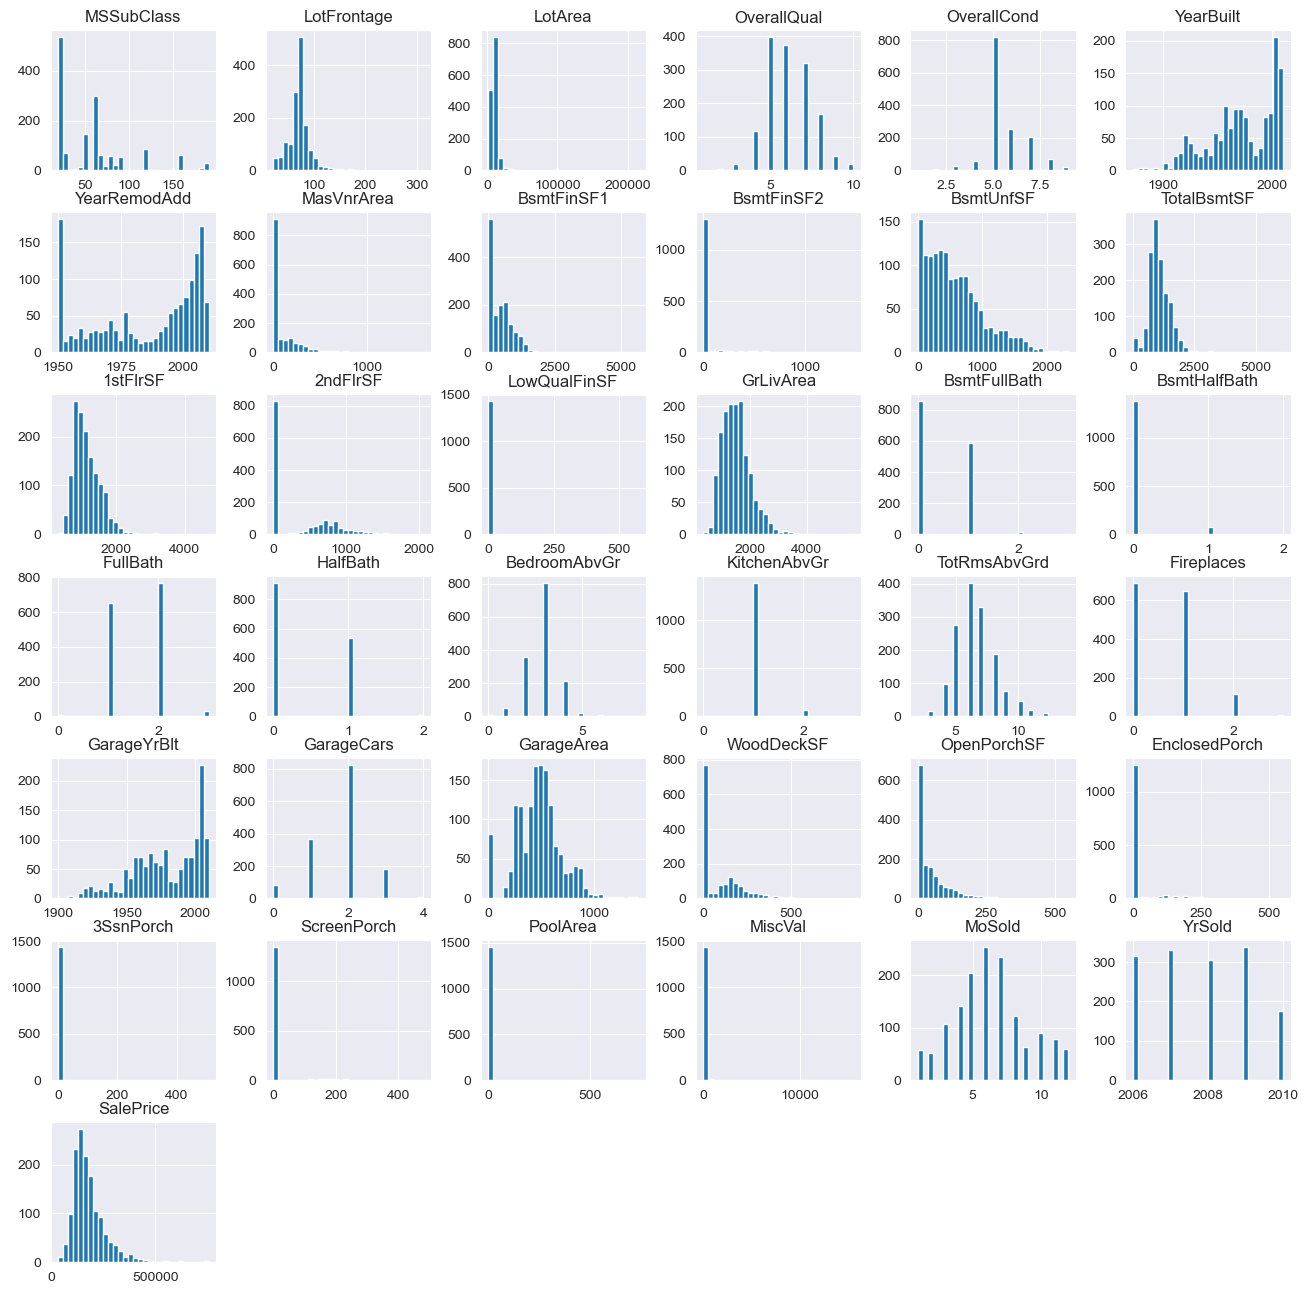

In [95]:
train_df.drop('Id', axis=1).hist(bins=30, figsize=(16,16))
plt.show()

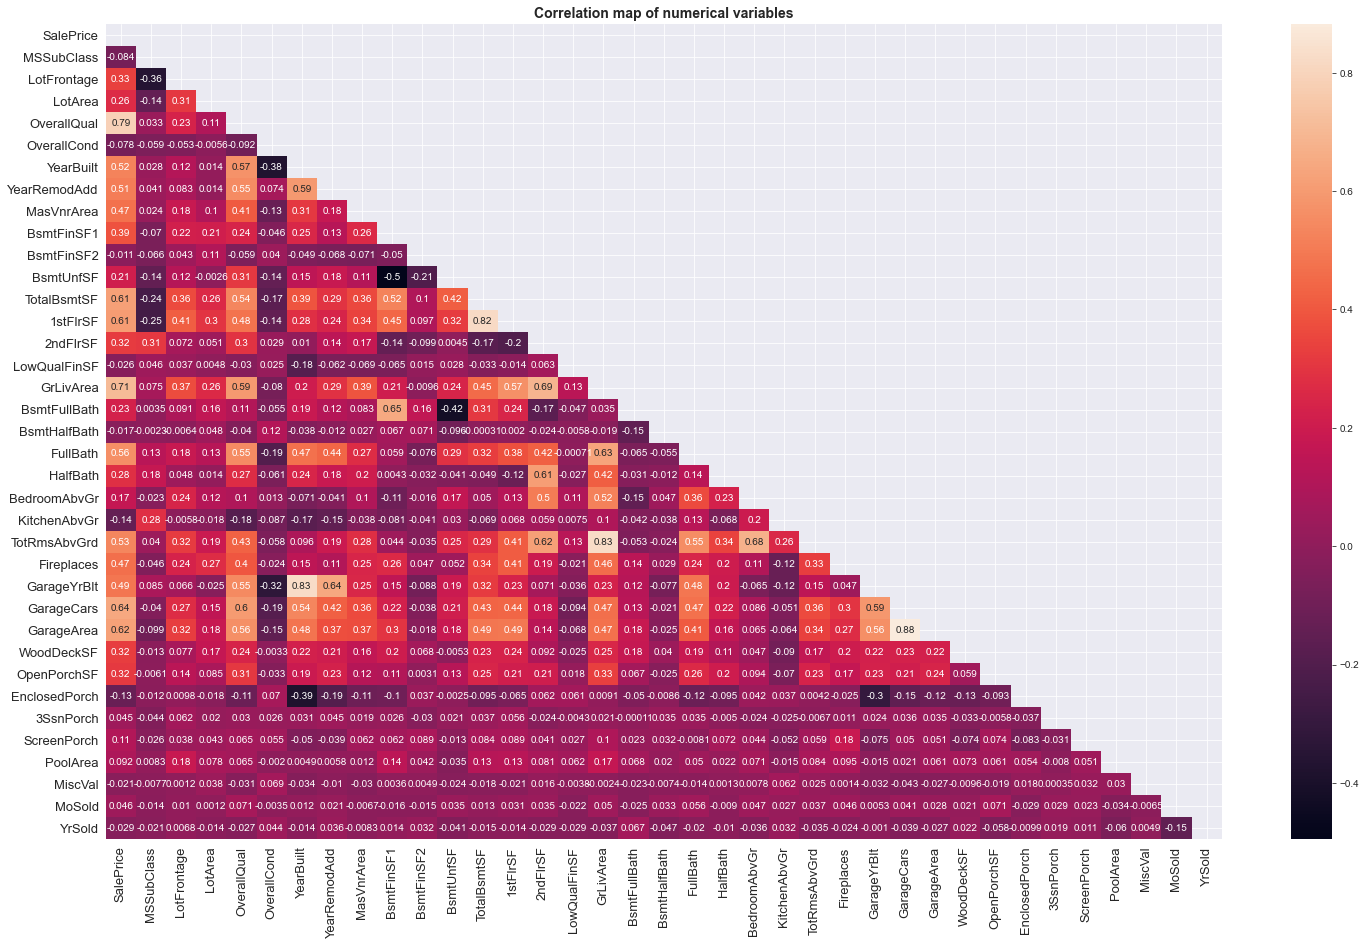

In [16]:
fig, ax = plt.subplots(figsize=(25,15))
sns.heatmap(data=train_df[['SalePrice','MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold']].corr(), annot=True, mask = np.triu(np.ones_like(train_df[['SalePrice','MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold']].corr(), dtype=bool)))

plt.title('Correlation map of numerical variables', fontsize=14, fontweight = 'bold')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

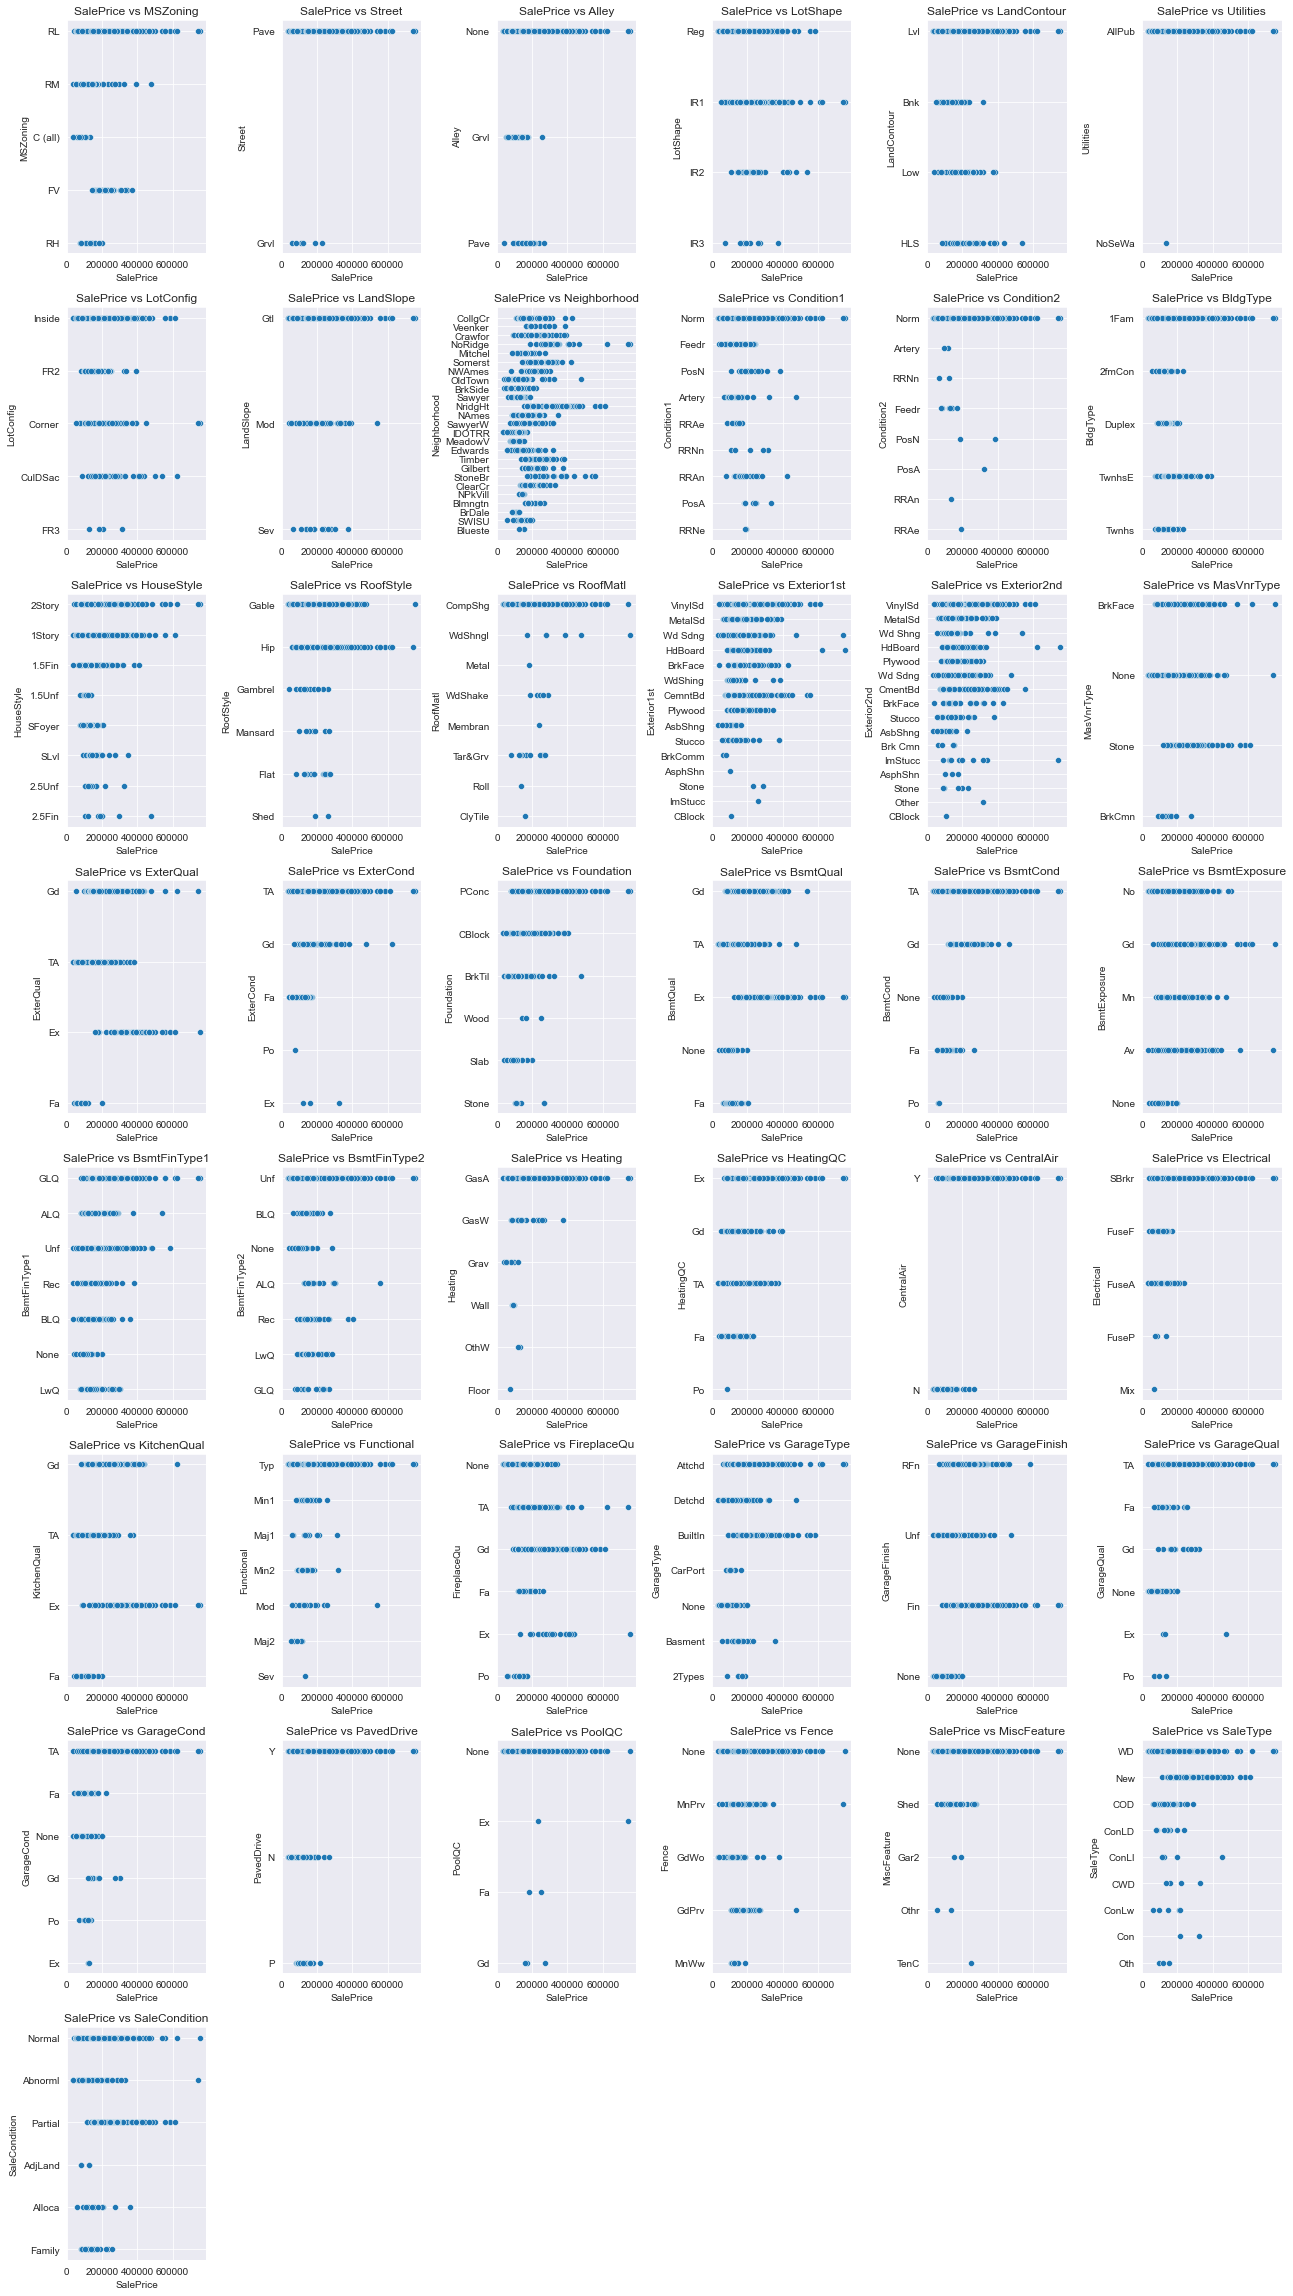

In [17]:
import math

# Assuming 'train_df' is your DataFrame

# List of categorical columns
object_columns = train_df.select_dtypes(include=['object']).columns

# Calculate the number of rows and columns needed for the subplot grid
num_plots = len(object_columns)
num_rows = math.ceil(num_plots / 6)
num_cols = min(num_plots, 6)

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 4 * num_rows))

# Flatten the axes array if there is only one row
axes = axes.flatten() if num_rows > 1 else [axes]

# Loop through the categorical columns and create scatter plots
for i, col in enumerate(object_columns):
    sns.scatterplot(data=train_df, x='SalePrice', y=col, ax=axes[i])
    axes[i].set_title(f'SalePrice vs {col}')

# Remove empty subplots if there are fewer than 6 columns
for i in range(num_plots, num_rows * num_cols):
    fig.delaxes(axes[i])

# Adjust layout
plt.tight_layout()
plt.show()


In [96]:
def preprocess_data(df):
    """
    This function is created to preprocess the df
    """
    
    df_new = df.copy()
    
    df_new['HouseAge'] = df_new['YrSold'] - df_new['YearBuilt']
    df_new['TotalSF'] = df_new['TotalBsmtSF'] + df_new['1stFlrSF'] + df_new['2ndFlrSF']
    df_new['TotalBath'] = df_new['FullBath'] + df_new['HalfBath'] + df_new['BsmtFullBath'] + df_new['BsmtHalfBath']
    df_new['TotalPorchSF'] = df_new['OpenPorchSF'] + df_new['EnclosedPorch'] + df_new['3SsnPorch'] + df_new['ScreenPorch']
    
    df_new.drop(['Street', 'Alley', 'LotShape', 'LandContour',
    'YearRemodAdd', 'MasVnrType', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'FullBath', 'HalfBath',
    'BsmtFullBath', 'BsmtHalfBath',
    'OpenPorchSF','EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolQC', 'PoolArea',
    'MiscVal',
    'GarageYrBlt', 
    'FireplaceQu', 'Fireplaces'], axis=1, inplace=True)
    
    return df_new

In [97]:
# Preprocessing the train df
train_df_preprocessed = preprocess_data(train_df)

# Preprocessing the test df
test_df_preprocessed = preprocess_data(test_df)

### Encoding categorical Features

In [98]:
# Getting object columns from train_df

object_columns = train_df_preprocessed.select_dtypes(include=['object']).columns

In [99]:
# Encoding categorical features of train df

for i in object_columns:
    le = LabelEncoder()
    train_df_preprocessed[i] = le.fit_transform(train_df_preprocessed[i])

In [100]:
# Encoding categorical features of test df

for i in object_columns:
    le = LabelEncoder()
    test_df_preprocessed[i] = le.fit_transform(test_df_preprocessed[i])

## Creating the Xgboost Model|

In [101]:
# Defining independed and depended variables
X = train_df_preprocessed.drop(['Id', 'SalePrice'], axis=1)

Y = train_df_preprocessed['SalePrice']

# Using train_test_split to split data into training and testing parts
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0) #0.2

In [64]:
# Define the parameter grid
param_grid = {
    'n_estimators': [5000, 10000],
    'max_depth': [4],
    'learning_rate': [0.01],
}

# Create an XGBRegressor instance
regressor = xgb.XGBRegressor(booster='gbtree', early_stopping_rounds=500, eval_metric='rmsle')

# Create GridSearchCV instance
grid_search = GridSearchCV(regressor, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2)

# Fit the model to the data
grid_search.fit(X_train, Y_train, eval_set=[(X_train, Y_train), (X_test, Y_test)], verbose=500)

# Print the best parameters and corresponding performance
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[0]	validation_0-rmsle:0.40659	validation_1-rmsle:0.39644
[500]	validation_0-rmsle:0.11533	validation_1-rmsle:0.14202
[1000]	validation_0-rmsle:0.09820	validation_1-rmsle:0.13931
[1500]	validation_0-rmsle:0.09291	validation_1-rmsle:0.13897
[2000]	validation_0-rmsle:0.08973	validation_1-rmsle:0.13908
[2149]	validation_0-rmsle:0.08900	validation_1-rmsle:0.13930
[CV] END .learning_rate=0.01, max_depth=4, n_estimators=5000; total time=  11.0s
[0]	validation_0-rmsle:0.40312	validation_1-rmsle:0.39330
[500]	validation_0-rmsle:0.10876	validation_1-rmsle:0.12961
[1000]	validation_0-rmsle:0.09493	validation_1-rmsle:0.12683
[1500]	validation_0-rmsle:0.09012	validation_1-rmsle:0.12538
[2000]	validation_0-rmsle:0.08732	validation_1-rmsle:0.12474
[2500]	validation_0-rmsle:0.08564	validation_1-rmsle:0.12441
[3000]	validation_0-rmsle:0.08452	validation_1-rmsle:0.12416
[3500]	validation_0-rmsle:0.08372	validation_1-rmsle:0.12416
[3757]	validat

In [102]:
# Fitting the xgboost model with best parameters from grid search cv
regressor = xgb.XGBRegressor(booster = 'gbtree',
                      n_estimators = 5000,
                    early_stopping_rounds=500,
                    #objective = 'reg:linear',
                      max_depth=4,
                      eval_metric='rmsle',
                      learning_rate = 0.01)

regressor.fit(X_train, Y_train,
       eval_set = [(X_train, Y_train), (X_test, Y_test)],
       verbose = 500)

[0]	validation_0-rmsle:0.40693	validation_1-rmsle:0.39689
[500]	validation_0-rmsle:0.09217	validation_1-rmsle:0.13170
[1000]	validation_0-rmsle:0.06903	validation_1-rmsle:0.12607
[1500]	validation_0-rmsle:0.05671	validation_1-rmsle:0.12532
[2000]	validation_0-rmsle:0.04754	validation_1-rmsle:0.12509
[2500]	validation_0-rmsle:0.04050	validation_1-rmsle:0.12504
[2900]	validation_0-rmsle:0.03638	validation_1-rmsle:0.12548


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=500,
             enable_categorical=False, eval_metric='rmsle', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=5000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [103]:
predictions_test = regressor.predict(X_test)

#from sklearn.metrics import mean_squared_log_error
RMSLE = np.sqrt(mean_squared_log_error(Y_test, predictions_test))
print("The score is %.5f" % RMSLE )

The score is 0.12492


## Predicting the test_df data

In [104]:
y_predict = regressor.predict(test_df_preprocessed.drop(['Id'], axis=1))

In [105]:
submission_df = pd.DataFrame({'Id': test_df['Id'], 'SalePrice': y_predict})
submission_df.to_csv('submission.csv', index=False)
submission_df.head(10)

,Id,SalePrice
0,1461,127675.593750
1,1462,179640.406250
2,1463,179135.859375
3,1464,189209.984375
4,1465,183825.515625
5,1466,166937.140625
6,1467,174418.312500
7,1468,167121.531250
8,1469,190496.453125
9,1470,131943.109375
